In [71]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [70]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [72]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = y_train % 2  # Convert labels to 0 (even) and 1 (odd)
y_test = y_test % 2

# Mark a subset of positive instances as unlabeled
positive_indices = np.where(y_train == 1)[0]
unlabeled_indices = np.random.choice(positive_indices, size=int(len(positive_indices) * 0.6), replace=False)
y_train[unlabeled_indices] = 0  # Marking unlabeled


X = x_train  # Your feature matrix

# Preparing 's', the binary indicator vector
# Start by marking all instances as 'unlabeled' (0)
s = np.zeros_like(y_train)
# Then, mark the originally positive instances as 'labeled' (1), excluding those you've marked as unlabeled
s[positive_indices] = 1
s[unlabeled_indices] = 0 # Ensure that the subset you've chosen to remain unlabeled stays that way

In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization

# First Classifier Model
model_1 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),  # Layer 1
    Activation('relu'),
    Conv2D(64, (3, 3)),  # Layer 2
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),  # Layer 3
    Activation('relu'),
    Conv2D(128, (3, 3)),  # Layer 4
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128),  # Layer 5
    Activation('relu'),
    Dense(1),  # Output Layer
    Activation('sigmoid')
])

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [74]:
# Policy-Network Model
# model_2 = Sequential([
#     Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),  # Layer 1
#     Activation('relu'),
#     Conv2D(64, (3, 3)),  # Layer 2
#     Activation('relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(64, (3, 3), padding='same'),  # Layer 3
#     Activation('relu'),
#     Flatten(),
#     Dense(64),  # Layer 4
#     Activation('relu'),
#     Dense(2),  # Output Layer: Assuming 2 actions for simplification
#     Activation('softmax')
# ])


model_2 = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)),  # Layer 1
    Activation('relu'),
    Conv2D(64, (3, 3)),  # Layer 2
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),  # Layer 3
    Activation('relu'),
    Flatten(),
    Dense(64),  # Layer 4
    Activation('relu'),
    Dense(2),  # Corrected Output Layer: 2 units for softmax
    Activation('softmax')
])


In [75]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical

class PUClassifierNN(object):
    def __init__(self, model_1=None, model_2=None, n_folds=2):
        self.model_1 = model_1  # The first 6-layer CNN classifier
        self.model_2 = model_2  # The second policy-network reinforcement neural network
        self.n_folds = n_folds
        self.c = None  # To store the constant c representing the proportion of positive instances
        self.history_1 = None
        self.history_2 = None

    def fit_model_1(self, X, s):
        # Fit the first model on labeled data only
        X_labeled = X[s == 1]  # Use only labeled data (s == 1)
        y_labeled = np.ones((X_labeled.shape[0], 1))  # Labels are all 1 for positive class
        
        self.model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.history_1 = self.model_1.fit(X_labeled, y_labeled, epochs=300, batch_size=32, validation_split=0.1)

    def estimate_c(self, X, s):
        # Estimate the constant c using the first model
        X_unlabeled = X[s == 0]  # Use unlabeled data
        preds = self.model_1.predict(X_unlabeled)
        self.c = np.mean(preds)

    def fit_model_2(self, X, s):
        # Prepare the dataset for the second model
        X_positive = X[s == 1]
        X_unlabeled = X[s == 0]
        y_positive = np.ones((X_positive.shape[0], 1))
        y_unlabeled = self.model_1.predict(X_unlabeled)  # Use model_1 to predict

        # Combine positive and unlabeled data, considering unlabeled as both positive and negative
        X_train = np.concatenate([X_positive, X_unlabeled], axis=0)
        y_train = np.concatenate([y_positive, y_unlabeled], axis=0)

        # Sample weights to adjust the influence of unlabeled data
        w_unlabeled = (1 - self.c) / self.c * (y_unlabeled / (1 - y_unlabeled))
        # sample_weight = np.concatenate([np.ones(y_positive.shape), w_unlabeled[:, 0]], axis=0)
        # Flatten the array of ones to match the dimensions of w_unlabeled
        sample_weight = np.concatenate([np.ones(y_positive.shape[0]), w_unlabeled[:, 0]], axis=0)


        # Fit the second model on the combined dataset
        y_train_one_hot = to_categorical(y_train)
        self.model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # self.model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.history_2 =self.model_2.fit(X_train, y_train_one_hot, sample_weight=sample_weight, epochs=300, batch_size=32, validation_split=0.1)

    def fit(self, X, s):
        # Fit the first model and estimate c
        self.fit_model_1(X, s)
        self.estimate_c(X, s)

        # Fit the second model using the estimated c
        self.fit_model_2(X, s)


# Instantiate the PUClassifierNN with the defined models
pu_classifier_nn = PUClassifierNN(model_1=model_1, model_2=model_2, n_folds=5)

# Fit the PUClassifierNN with your data (X, s), where X is your feature matrix and s is your binary indicator vector
pu_classifier_nn.fit(X, s)


Epoch 1/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9814 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/300
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/300
344/344 ━━━━━━━━━━━━━━━━━

C:\Users\FH-Deg\AppData\Local\Temp\7\ipykernel_36592\3035259833.py:43: RuntimeWarning: divide by zero encountered in divide
  w_unlabeled = (1 - self.c) / self.c * (y_unlabeled / (1 - y_unlabeled))
C:\Users\FH-Deg\AppData\Local\Temp\7\ipykernel_36592\3035259833.py:43: RuntimeWarning: invalid value encountered in multiply
  w_unlabeled = (1 - self.c) / self.c * (y_unlabeled / (1 - y_unlabeled))


Epoch 1/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.0043 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 2/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 3/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 4/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 5/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 6/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 7/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.0000e+00 - loss: nan - val_accuracy: 0.0000e+00 - val_loss: nan
Epoch 8/300
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - 

In [ ]:
for epoch in range(epochs=3):
    for i in range(len(X)):
        state = X[i:i+1]  # Current "state" is the image
        action_probabilities = model_2.predict(state)  # Model predicts action probabilities
        action = np.argmax(action_probabilities)  # Choose action with highest probability

        true_label = s[i]
        reward = 1 if action == true_label else -1  # Simplified reward

        # Here you'd typically update your model based on the action taken and the reward received
        # This might involve calculating gradients and applying them to update the model weights
        # However, the exact mechanism would depend on the RL algorithm being used (e.g., Q-learning, policy gradients)

    # Optionally evaluate model performance on a validation set after each epoch


In [76]:
print(pu_classifier_nn.history_1)

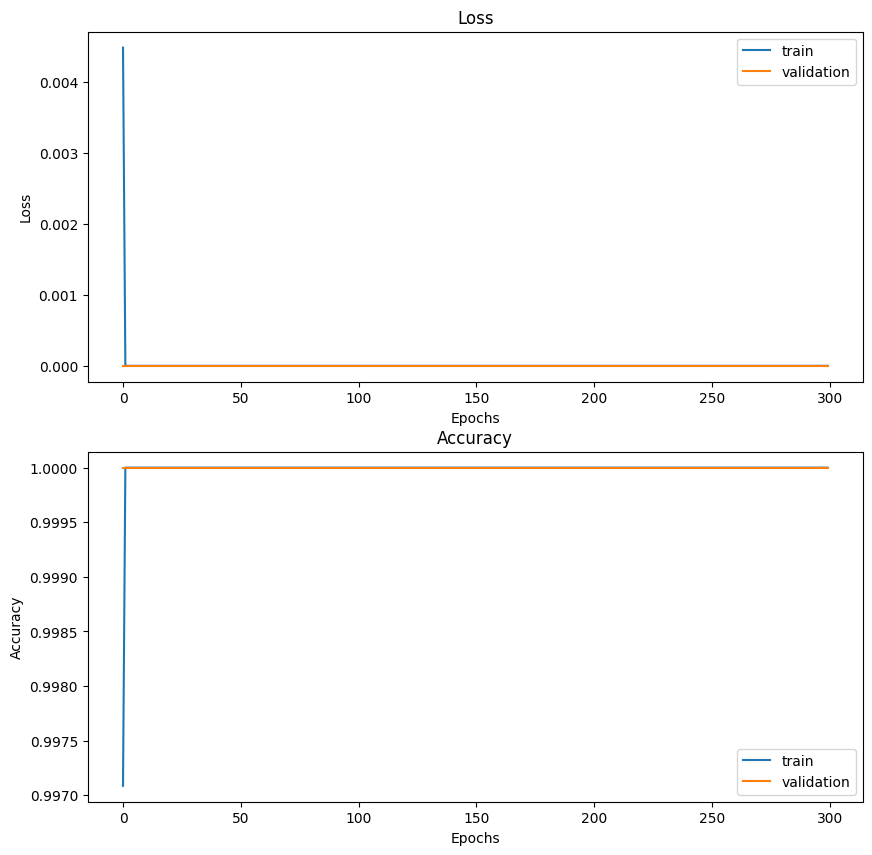

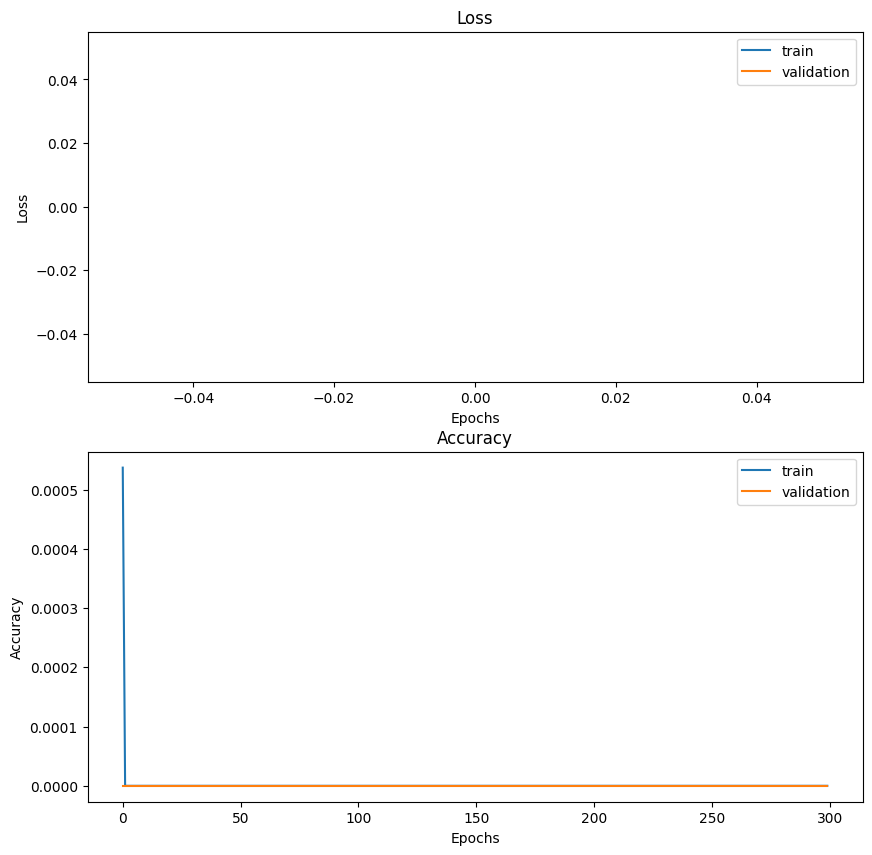

In [77]:
print(pu_classifier_nn.history_2)
def plot_history(history):
    """Plot training and validation loss and accuracy."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Assuming you have stored the history of training your models as `history_1` and `history_2`
plot_history(pu_classifier_nn.history_1)  # For the first classifier
plot_history(pu_classifier_nn.history_2)  # For the second classifier

In [ ]:
# Assuming model_1 is your first classifier (6-layer CNN)
# X_train is your training images, y_train is your modified labels with 1 for labeled positive, 0 for unlabeled and negative

# Filter only labeled data
labeled_mask = (y_train == 1)
X_labeled = x_train[labeled_mask]
y_labeled = y_train[labeled_mask]

model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(X_labeled, y_labeled, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9865 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 9s 2

In [ ]:
probabilities = model_1.predict(x_train)  # Estimate probabilities for all data


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step


In [ ]:
# The combined dataset for the second classifier will include all instances
X_combined = x_train
y_combined = y_train  # Here, 1s are labeled positive, 0s are unlabeled and negative

# The sample weights will be 1 for labeled positive instances, and the predicted probabilities for unlabeled/negative instances
sample_weights = np.ones_like(y_train, dtype=float)  # Start with all ones
sample_weights[y_train == 0] = probabilities[y_train == 0].flatten()  # Adjust weights for unlabeled/negative

# Reshape if your model expects a different input shape
X_combined = X_combined.reshape((-1, 28, 28, 1))  # Reshaping for CNN input, if needed


In [ ]:

# Compile the model for a multi-class classification problem
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoded format
y_combined_one_hot = to_categorical(y_combined)

# Fit the model with one-hot encoded labels
history_2 = model_2.fit(X_combined, y_combined_one_hot, sample_weight=sample_weights, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7956 - loss: 0.3945 - val_accuracy: 0.7969 - val_loss: 0.3556
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.8002 - loss: 0.3548 - val_accuracy: 0.7969 - val_loss: 0.3526
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.7963 - loss: 0.3488 - val_accuracy: 0.7969 - val_loss: 0.3529
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.7929 - loss: 0.3482 - val_accuracy: 0.7967 - val_loss: 0.3525
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7923 - loss: 0.3444 - val_accuracy: 0.7968 - val_loss: 0.3539
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.7941 - loss: 0.3393 - val_accuracy: 0.7949 - val_loss: 0.3571
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7987 - loss: 0.3325 - val_accuracy: 0.7927 - val_loss: 0.3622
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.8047 -

In [ ]:
  # Reshape test data if needed
# test_loss, test_acc = model_2.evaluate(X_test_reshaped, y_test)  # Use true labels here for evaluation
# print(f'Test accuracy: {test_acc}')

from tensorflow.keras.utils import to_categorical

X_test_reshaped = x_test.reshape((-1, 28, 28, 1))
# One-hot encode y_test
y_test_one_hot = to_categorical(y_test)

# Now use the one-hot encoded labels for evaluation
test_loss, test_acc = model_2.evaluate(X_test_reshaped, y_test_one_hot)
print(f'Test accuracy: {test_acc}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6340 - loss: 0.5985
Test accuracy: 0.6331999897956848


# Visual

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


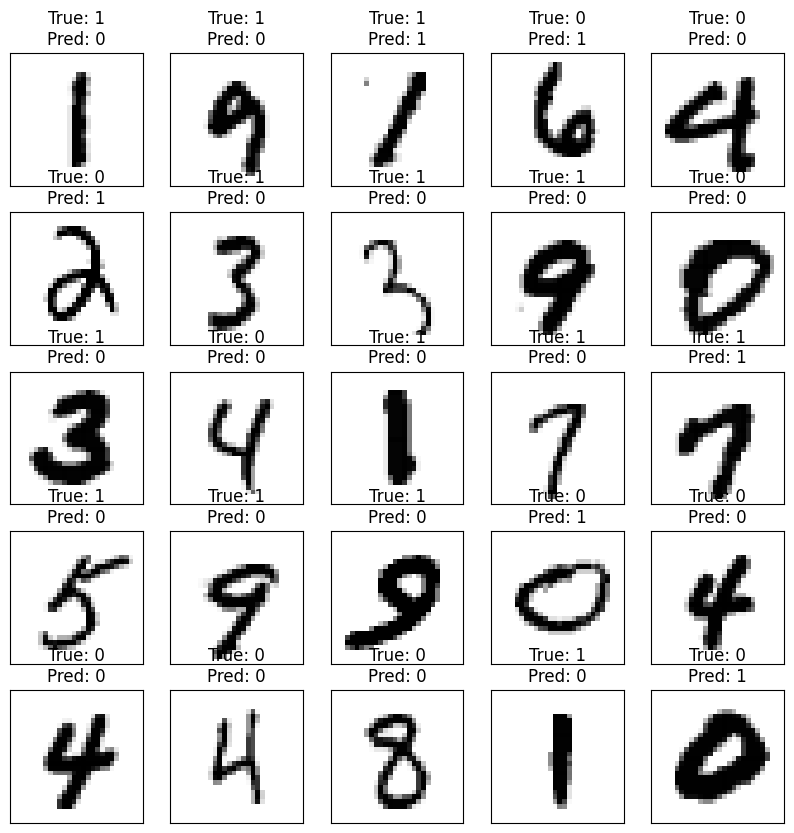

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, labels, predictions=None):
    """Plot images with their labels. Show predictions if provided."""
    n = images.shape[0]
    sqrt_val = int(np.ceil(np.sqrt(n)))
    fig, axes = plt.subplots(sqrt_val, sqrt_val, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i >= n:
            break
        ax.imshow(images[i], cmap='binary')
        
        if predictions is not None:
            ax.set_title(f"True: {labels[i]}\nPred: {predictions[i]}")
        else:
            ax.set_title(f"Label: {labels[i]}")
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Predictions from the second classifier
predictions = model_2.predict(X_test_reshaped)
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Assuming binary classification

# Selecting a few images to display
indices = np.random.choice(range(len(x_test)), 25, replace=False)  # Randomly select 25 images
selected_images = x_test[indices]
selected_labels = y_test[indices]
selected_predictions = predicted_classes[indices]

# Plotting
plot_images(selected_images, selected_labels, selected_predictions)


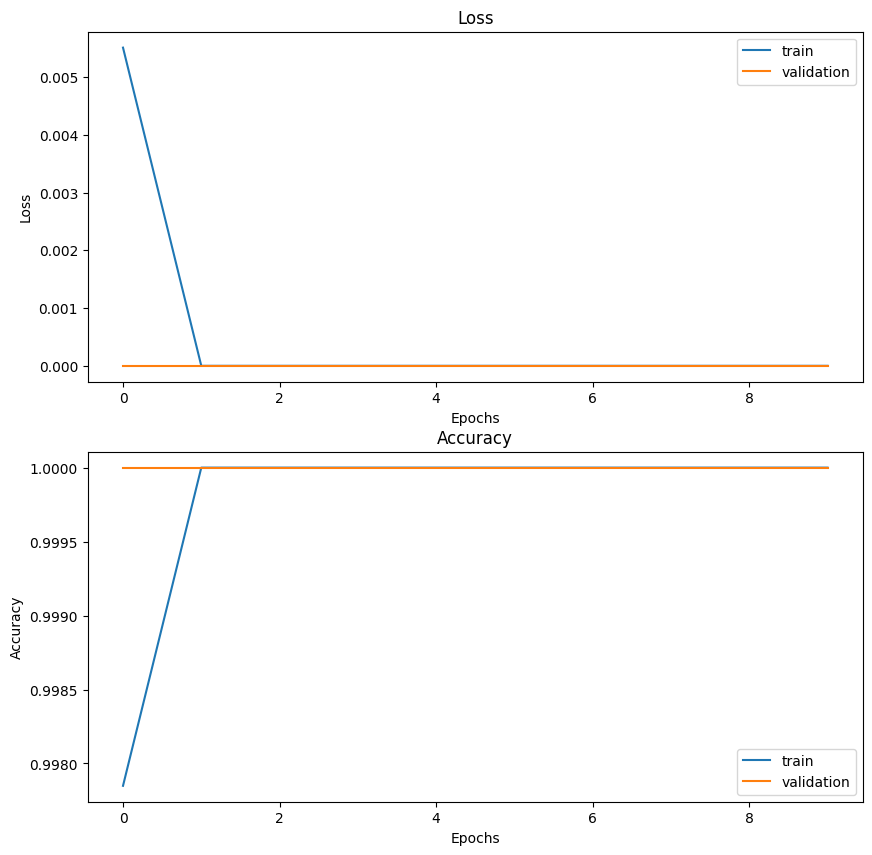

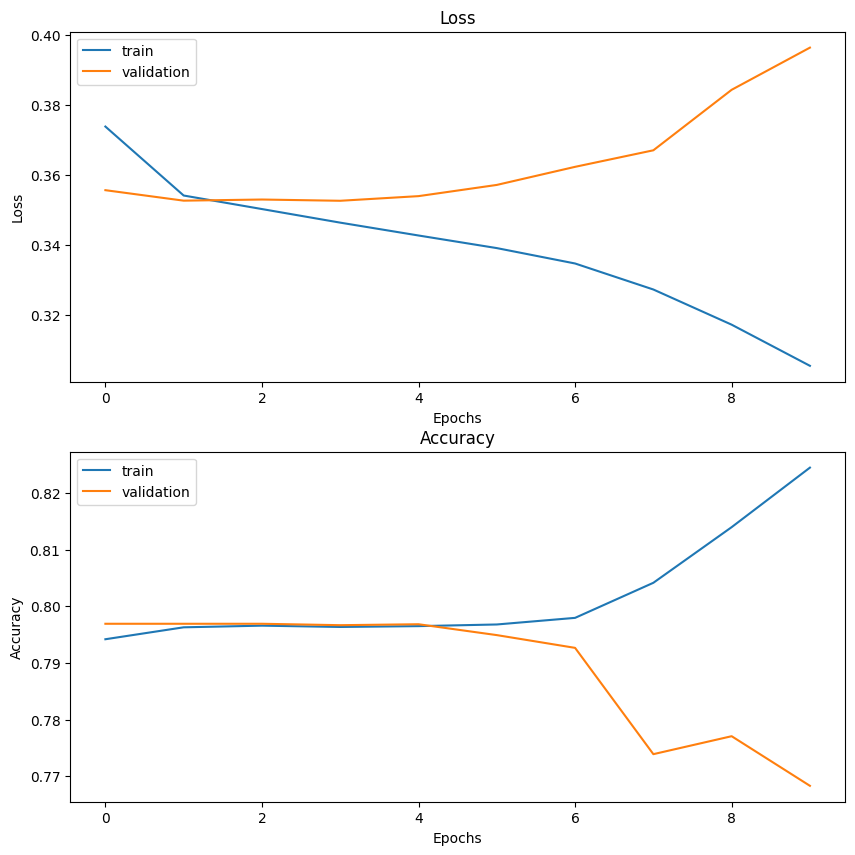

In [ ]:
def plot_history(history):
    """Plot training and validation loss and accuracy."""
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

# Assuming you have stored the history of training your models as `history_1` and `history_2`
plot_history(history_1)  # For the first classifier
plot_history(history_2)  # For the second classifier
